# Ajout des données

In [ ]:
import io
from google.colab import drive
import pandas as pd
import numpy as np
drive.mount('/content/drive')
source_folder =r'/content/drive/My Drive/data_deeplearning.csv'
df = pd.read_csv(source_folder,sep=";")

Mounted at /content/drive


# Preprocessing

Suppression des lyrics qui ne sont pas en français ni en anglais

In [ ]:
!pip install langdetect
from langdetect import detect
def lang_d(lyric):
  try :
    lang = detect(lyric)
    if lang not in ['fr','en'] :
      return None
    else:
      return lyric
  except:
    return None

df['lyrics'] = df['lyrics'].apply(lang_d)
df = df.dropna()

     |████████████████████████████████| 983kB 7.5MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=085bc568aca0959fa01440d7344bf90af3100ee5c21992f40e7f1d0e32feb793
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


Suppression des genres peu représentés

In [ ]:
df = df.drop(df[(df['tag'] == 'non-music') | (df['tag'] == 'country')].index)

Traitement des mots et supression des stop_words

In [ ]:
import re
import nltk 
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

stop_words = stopwords.words('english') + stopwords.words('french')
def stop_word_delete(lyric,stop_words=stop_words):
  return " ".join([word for word in lyric.split(" ") if word not in stop_words ])

def preprocessing(lyric):
  lyric = [line for line in lyric.split("\n") if line !='']
  lyric = pd.Series(filter(lambda x : '[' not in x, lyric))
  lyric = [re.sub("\d+","",line.lower()) for line in lyric]
  lyric = " ".join([re.sub("\"","",line.lower()) for line in lyric])
  return lyric

df['lyrics_prepro'] = df['lyrics'].apply(preprocessing)
df['lyrics_prepro'] = df['lyrics_prepro'].apply(stop_word_delete)
df['lyrics_prepro'] = df['lyrics_prepro'].apply(sent_tokenize)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Augmentation du nombre de données

Application du Sent_tokenizer pour augmenter le nombre de données

In [ ]:
df_fit = pd.DataFrame(columns=['tag','lyrics'])
df_fit['lyrics'] = [sent for lyrics in df['lyrics_prepro'] for sent in lyrics if len(sent) > 10] 
df_fit['tag'] = [tag for tag, lyrics in df[['tag','lyrics_prepro']].values for sent in lyrics if len(sent) > 10]
df_fit.count()

tag       25734
lyrics    25734
dtype: int64

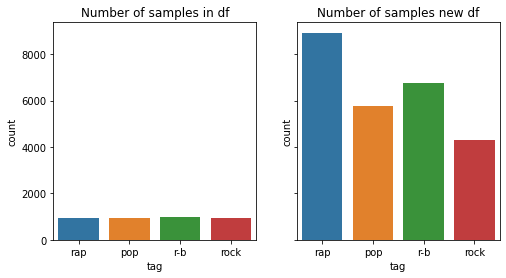

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(8,4),sharey=True)
axarr[0].set_title("Number of samples in df")
sns.countplot(x=df['tag'], ax=axarr[0])
axarr[1].set_title("Number of samples new df")
sns.countplot(x=df_fit['tag'], ax=axarr[1])
plt.show()

# Analyse du vocabulaire

Séparation label et contenu

In [ ]:
X = df_fit['lyrics']
Y = pd.get_dummies(df_fit['tag']).values

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=50000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X)
vocab_size = len(tokenizer.word_index)
print("nombre de mots : ",vocab_size)
max_len= max([len(line.split(" ")) for line in X ])
print("nombre maximum de mot par ligne : ",max_len)
nb_word = np.mean([len(line.split(" ")) for line in X ])
print("nombre moyen de mot par ligne : ",round(nb_word,1))

nombre de mots :  36927
nombre maximum de mot par ligne :  726
nombre moyen de mot par ligne :  39.4


# Train/test

In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=70, padding='post')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)
print("X")
print(X_train.shape,y_train.shape)
print("label")
print(X_test.shape,y_test.shape)

X
(20587, 70) (20587, 4)
label
(5147, 70) (5147, 4)


# models

Import

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, SpatialDropout1D, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization as BatchNorm
from keras.layers import Dropout
from keras import optimizers

model 1

In [ ]:
def model():
    optimizer = optimizers.RMSprop(lr=0.01)
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


model=model()
epochs = 10    
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/10
290/290 [==============================] - 65s 216ms/step - loss: 1.3757 - accuracy: 0.3394 - val_loss: 1.3857 - val_accuracy: 0.3327
Epoch 2/10
290/290 [==============================] - 62s 212ms/step - loss: 1.2857 - accuracy: 0.3890 - val_loss: 1.1933 - val_accuracy: 0.4789
Epoch 3/10
290/290 [==============================] - 62s 214ms/step - loss: 1.0885 - accuracy: 0.5241 - val_loss: 1.1689 - val_accuracy: 0.4973
Epoch 4/10
290/290 [==============================] - 62s 214ms/step - loss: 0.9343 - accuracy: 0.6069 - val_loss: 1.1809 - val_accuracy: 0.5143
Epoch 5/10
290/290 [==============================] - 62s 214ms/step - loss: 0.8191 - accuracy: 0.6582 - val_loss: 1.2174 - val_accuracy: 0.5168
Epoch 6/10
290/290 [==============================] - 62s 214ms/step - loss: 0.7397 - accuracy: 0.6904 - val_loss: 1.2942 - val_accuracy: 0.5085


model 2

In [ ]:
def model_2():
    optimizer = optimizers.RMSprop(lr=0.01)
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(50))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Activation('relu'))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(4))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


model_2=model_2()
epochs = 100    
batch_size = 64

history = model_2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
290/290 [==============================] - 66s 216ms/step - loss: 1.4919 - accuracy: 0.2948 - val_loss: 1.4143 - val_accuracy: 0.2244
Epoch 2/5
290/290 [==============================] - 62s 215ms/step - loss: 1.3595 - accuracy: 0.3375 - val_loss: 1.3609 - val_accuracy: 0.3594
Epoch 3/5
290/290 [==============================] - 62s 215ms/step - loss: 1.2640 - accuracy: 0.4061 - val_loss: 1.2206 - val_accuracy: 0.4517
Epoch 4/5
290/290 [==============================] - 62s 214ms/step - loss: 1.1170 - accuracy: 0.5103 - val_loss: 1.1679 - val_accuracy: 0.4706
Epoch 5/5
290/290 [==============================] - 62s 215ms/step - loss: 1.0076 - accuracy: 0.5804 - val_loss: 1.2116 - val_accuracy: 0.4750


accuracy

In [ ]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
accr = model_2.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

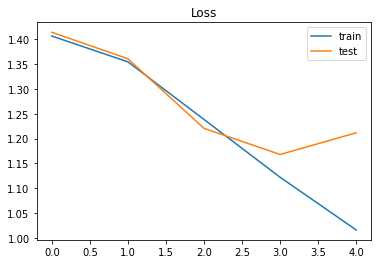

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

# Prediction

In [ ]:
lyric = df['lyrics'][51]
lyric = preprocessing(lyric)
print(lyric)
lyric = stop_word_delete(lyric)
print(lyric)
list_lyrics = [sent for sent in sent_tokenize(lyric) if len(sent) > 10] 
print(list_lyrics)

everybody get up everybody get up hey, hey, hey hey, hey, hey (uh) hey, hey, hey (ha-ha! woo!) tune me up if you can't hear what i'm trying to say (hey girl, come here!) if you can't read from the same page (hey) maybe i'm going deaf (hey, hey, hey) maybe i'm going blind (hey, hey, hey) maybe i'm out of my mind (hey, hey, hey) everybody get up okay, now he was close tried to domesticate you but you're an animal baby, it's in your nature (meow) just let me liberate you (hey, hey, hey) you don't need no takers (hey, hey, hey) that man is not your maker (hey, hey, hey) and that's why i'm gon' take a (everybody get up) good girl i know you want it (hey) i know you want it i know you want it you're a good girl can't let it get past me you're far from plastic (alright) talkin' 'bout getting blasted i hate these blurred lines i know you want it (hey) i know you want it (oh yeah) i know you want it but you're a good girl the way you grab me must wanna get nasty go ahead, get at me everybody ge

Prediction pour chaque phrases d'un texte

In [ ]:
for l in list_lyrics :
  l = [l]
  seq = tokenizer.texts_to_sequences(l)
  padded = pad_sequences(seq, maxlen=70)
  pred = model.predict(padded)
  labels = pd.unique(df_fit['tag'])
  print(pred, labels[np.argmax(pred)])

[[0.41107747 0.28426164 0.15886858 0.14579237]] rap
[[0.04609607 0.8792961  0.06427729 0.01033061]] pop
[[0.1925233  0.583643   0.2157262  0.00810746]] pop
[[0.41197255 0.35353822 0.18842025 0.04606907]] rap
[[0.12717897 0.34854323 0.36197236 0.16230544]] r-b
[[0.61470264 0.26072156 0.08975822 0.0348175 ]] rap
[[0.32517257 0.5739543  0.09201894 0.00885414]] pop
[[0.5069817  0.12336759 0.02833851 0.3413123 ]] rap
[[0.04800818 0.10499429 0.8270527  0.01994485]] r-b
[[1.1480754e-01 7.5949639e-01 1.2497378e-01 7.2225567e-04]] pop
[[0.10500415 0.35831913 0.12407397 0.4126028 ]] rock
[[0.42676026 0.4212783  0.09315382 0.05880764]] rap
